# Tutorial 1: Training and Evaluation of Logistic Regression on Encrypted Data

## Setup

In [1]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time
from time import sleep

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import psutil
import threading
from tqdm import tqdm

torch.random.manual_seed(10)
random.seed(10)
np.random.seed(10) 

## dataset

In [2]:
def cic_dataset():
    save_list = ["X_train", "X_test", "y_train", "y_test"]
    
    for i in save_list:
        save_path = 'data/' + i+'.csv'
        globals()["{}".format(i)] = pd.read_csv(save_path)
    
    x_tra = torch.tensor(X_train.values).float()
    y_tra = torch.tensor(y_train.values).float()
    x_te = torch.tensor(X_test.values).float()
    y_te = torch.tensor(y_test.values).float()
    
    print("############# Data summary #############")
    print(f"x_train has shape: {x_tra.shape}")
    print(f"y_train has shape: {y_tra.shape}")
    print(f"x_test has shape: {x_te.shape}")
    print(f"y_test has shape: {y_te.shape}")
    print("#######################################")
    return x_tra, y_tra, x_te, y_te

In [3]:
def test_dataset():
    save_path = 'data/test_clear3.csv'
    data = pd.read_csv(save_path)
    print(data.shape)
    
    y = data['Label']
    X = data[:]
    X = X.drop(labels='Label',axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        shuffle=True, random_state=34)
    
    scaler = MinMaxScaler(feature_range=(0,1)) 
    scaler.fit(X_train)
    transformed_X_train = scaler.transform(X_train)
    transformed_X_test = scaler.transform(X_test) 
    
    x_train = torch.tensor(transformed_X_train).float()
    y_train = torch.tensor(y_train.values).float()
    x_test = torch.tensor(transformed_X_test).float()
    y_test = torch.tensor(y_test.values).float()
    
    y_test = y_test.reshape(-1,1)
    y_train = y_train.reshape(-1,1)
    
    print("############# Data summary #############")
    print(f"x_train has shape: {x_train.shape}")
    print(f"y_train has shape: {y_train.shape}")
    print(f"x_test has shape: {x_test.shape}")
    print(f"y_test has shape: {y_test.shape}")
    print("#######################################")
    
    return x_train, y_train, x_test, y_test

In [4]:
# select dataset
x_train, y_train, x_test, y_test = cic_dataset()
# x_train, y_train, x_test, y_test = test_dataset()

############# Data summary #############
x_train has shape: torch.Size([961, 291])
y_train has shape: torch.Size([961, 1])
x_test has shape: torch.Size([241, 291])
y_test has shape: torch.Size([241, 1])
#######################################


## memory usage

In [5]:
st = time()
mem_buff = {}
mem_flag = [True]

def record_mem():    
    global mem_buff, st
    while mem_flag[0]:
        p = psutil.Process()
        rss = p.memory_info().rss/2**20        
        mem_buff[time()-st] = (rss)

In [6]:
def memory_usage(message: str = 'debug'):
    # current process RAM usage
    p2 = psutil.Process()
    rss = p2.memory_info().rss / 2 ** 20 # Bytes to MB
    # print(f"[{message}] memory usage: {rss: 10.5f} MB")
    return rss

## partial feature dataset

In [7]:
# index
pinx = [0, 1, 2, 3]
ninx = []
for i in range(len(x_test[1])):
    if i not in pinx:  
        ninx.append(i)

## Training a Logistic Regression Model

We will start by training a logistic regression model (without any encryption), which can be viewed as a single layer neural network with a single node. We will be using this model as a means of comparison against encrypted training and evaluation.

In [8]:
class LR(torch.nn.Module):
    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [9]:
n_features = x_train.shape[1]
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=1)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

In [10]:
# define the number of epochs for both plain and encrypted training
EPOCHS = 5

def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        # print(y.shape)
        # print(out.shape)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        # print(f"Loss at epoch {e}: {loss.data}")
    return model

LR_time = []
LR_mem = []
LR_mem_sub = []

sfm_s = memory_usage()

for i in tqdm(range(10)):
    mem_buff = {}
    mem_flag[0] = True
    st = time()
    t = threading.Thread(target = record_mem)
    t.start()
    
    
    sleep(0.0001)
    model = train(model, optim, criterion, x_train, y_train)
    sleep(0.0001)
    
    
    et = time()
    mem_flag[0] = False
    t.join()
    ft = et-st
    fm = mem_buff[max(mem_buff)]-mem_buff[min(mem_buff)]
    # print("time : ", et-st)
    # print("memory : ", mem_buff[max(mem_buff)]-mem_buff[min(mem_buff)])
    fm_s = memory_usage()
    LR_time.append(ft)
    LR_mem.append(fm)
    LR_mem_sub.append(fm_s)
# plt.title("Memory Tracing")
# plt.ylabel("Memory_usage")
# plt.xlabel("Time")
# plt.plot(mem_buff.keys(), [mem_buff[i] for i in mem_buff.keys()])
# plt.show()


print("LR_time : ", np.mean(LR_time))
print("====================")
print("LR_mem mean : ", np.mean(LR_mem))
print("LR_mem sum : ", np.sum(LR_mem))
print("LR_mem max : ", max(LR_mem), "   LR_mem min : ", min(LR_mem))
print("LR_mem : ", LR_mem)

print("====================")
print("LR_mem_sub : ", np.mean(LR_mem_sub))
print("LR_mem_first : ", sfm_s )
print("LR_mem_last : ", LR_mem_sub[-1])
print("LR_mem_sub : ", LR_mem_sub)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.10it/s]

LR_time :  0.06487276554107665
LR_mem mean :  0.358984375
LR_mem sum :  3.58984375
LR_mem max :  3.58984375    LR_mem min :  0.0
LR_mem :  [3.58984375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
LR_mem_sub :  511.13671875
LR_mem_first :  507.34765625
LR_mem_last :  511.16796875
LR_mem_sub :  [510.9375, 511.12890625, 511.15625, 511.15625, 511.15625, 511.1640625, 511.1640625, 511.16796875, 511.16796875, 511.16796875]


In [11]:
def accuracy(model, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(model, x_test, y_test)
print(f"Accuracy on plain test_set: {plain_accuracy}")

Accuracy on plain test_set: 1.0


## Training an Encrypted Logistic Regression Model on Encrypted Data

### privacy feature

In [12]:
enc_x_train = torch.tensor(np.array([]))

In [13]:
for i in pinx:
    if len(pinx) == 1:
        enc_x_train = x_train[: ,i].reshape(-1, 1)
    else:
        enc_x_train = torch.cat([enc_x_train, x_train[: ,i].reshape(-1, 1)], dim=1)

In [14]:
x_train2 = torch.tensor(np.array([]))
for i in ninx:
    if len(ninx) == 1:
        x_train2 = x_train[: ,i].reshape(-1, 1)
    else:
        x_train2 = torch.cat([x_train2, x_train[: ,i].reshape(-1, 1)], dim=1)

In [15]:
print("enc_x_train shape : ", enc_x_train.shape)
print("x_train2 shape : ", x_train2.shape)

enc_x_train shape :  torch.Size([961, 4])
x_train2 shape :  torch.Size([961, 287])


In [16]:
type(x_train2)

torch.Tensor

### Enc training

In [17]:
class EncryptedLR:
    def __init__(self, torch_lr, pinx, nidx):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()

        tmp = []
        for i in pinx:
            tmp.append(self.weight[i])
        self.w1 = tmp
        
        tmp = []  
        for i in ninx:
            tmp.append(self.weight[i])
        self.w2 = torch.tensor(np.array(tmp))
    
        self._delta_w1 = 0
        self._delta_w2 = 0
        self._delta_b = 0
        self._count = 0
        self.flow = []
        
    def forward(self, enc_x, x):
        self.flow.append("forward")
        tmp1 = enc_x.dot(self.w1)
        tmp2 = int(x.dot(self.w2))
        enc_out = tmp1 + tmp2 + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, x, enc_out, enc_y):
        self.flow.append("backward")
        out_minus_y = (enc_out - enc_y)
        self._delta_w1 += enc_x * out_minus_y
        out_minus_y = out_minus_y.decrypt()[0]
        self._delta_w2 += x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1
        
    def update_parameters(self):
        self.flow.append("update_parameters")
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.w1 -= self._delta_w1 * (1 / self._count) + self.w1 * 0.05
        self.w2 -= self._delta_w2 * (1 / self._count) + self.w2 * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w1 = 0
        self._delta_w2 = 0
        self._delta_b = 0
        self._count = 0
        # print("weight : ", self.weight.decrypt() , "bias : ", self.bias.decrypt())
    
    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return enc_x.polyval([0.5, 0.197, 0, -0.004])
    
    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        # print(out)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()    

    def plain_accuracy2(self, x_test, y_test, weight_cat):
        self.flow.append("plain_accuracy2")
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(weight_cat)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        # print(out)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()    
        
    def encrypt(self, context):
        self.flow.append("encrypt")
        self.w1 = ts.ckks_vector(context, self.w1)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.flow.append("decrypt")
        self.w1 = self.w1.decrypt()
        self.bias = self.bias.decrypt()

    def cat_weight(self):
        self.flow.append("cat_weight")
        weight_cat = self.w1 + self.w2.tolist()
        return weight_cat
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)


In [18]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

In [19]:
mem_buff = {}
mem_flag[0] = True

LR_time = []
LR_mem = []
LR_mem_sub = []

sfm_s = memory_usage()

for i in tqdm(range(100)):
    st = time()
    t = threading.Thread(target = record_mem)
    t.start()
    
    enc_x_train11 = [ts.ckks_vector(ctx_training, x.tolist()) for x in enc_x_train]
    enc_y_train11 = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
    
    et = time()
    mem_flag[0] = False
    t.join()

    ft = et-st
    fm = mem_buff[max(mem_buff)]-mem_buff[min(mem_buff)]
    fm_s = memory_usage()
    LR_time.append(ft)
    LR_mem.append(fm)
    LR_mem_sub.append(fm_s)


print("LR_time : ", np.mean(LR_time))
print("====================")
print("LR_mem mean : ", np.mean(LR_mem))
print("LR_mem sum : ", np.sum(LR_mem))
print("LR_mem max : ", max(LR_mem), "   LR_mem min : ", min(LR_mem))
print("LR_mem : ", LR_mem)

print("====================")
print("LR_mem_sub : ", np.mean(LR_mem_sub))
print("LR_mem_first : ", sfm_s )
print("LR_mem_last : ", LR_mem_sub[-1])
print("LR_mem_sub : ", LR_mem_sub)


enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in enc_x_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]

100%|█████████████████████████████████████████| 100/100 [24:18<00:00, 14.58s/it]


LR_time :  14.566640419960022
LR_mem mean :  1714.50390625
LR_mem sum :  171450.390625
LR_mem max :  1714.50390625    LR_mem min :  1714.50390625
LR_mem :  [1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 1714.50390625, 171

Distribution on plain data:


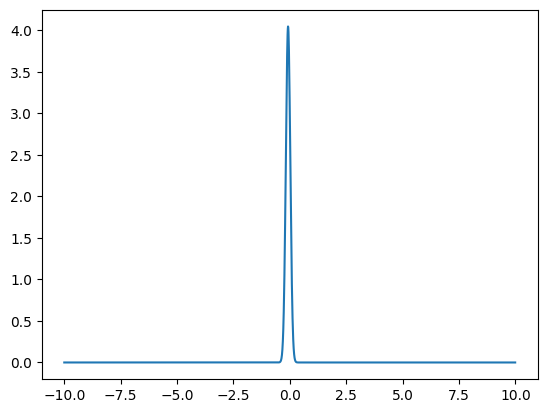

In [20]:
normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)
    
# plain distribution
lr = LR(n_features)
data = lr.lr(x_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    # plt.show()


Most of the data falls into $[-5,5]$, the sigmoid approximation should be good enough!

We finally reached the last part, which is about training an encrypted logistic regression model on encrypted data! You can see that we decrypt the weights and re-encrypt them again after every epoch, this is necessary since after updating the weights at the end of the epoch, we can no longer use them to perform enough multiplications, so we need to get them back to the initial ciphertext level. In a real scenario, this would translate to sending the weights back to the secret-key holder for decryption and re-encryption. In that case, it will result in just a few Kilobytes of communication per epoch.

In [21]:
type(x_train2[0])

torch.Tensor

In [22]:
main_list = []

LR_time = []
LR_mem = []
LR_mem_sub = []

sfm_s = memory_usage()

for iter in tqdm(range(100)):
    # eelr = EncryptedLR(lr)
    # eelr.encrypt(ctx_training)
    # # encrypted_out_distribution(eelr, enc_x_train)
    mem_buff = {}
    mem_flag[0] = True
    st = time()
    t = threading.Thread(target = record_mem)
    t.start()

    
    eelr = EncryptedLR(LR(n_features), pinx, ninx)
    accuracy = eelr.plain_accuracy(x_test, y_test)
    # print(f"Accuracy at epoch #0 is {accuracy}")
    
    times = []
    accuracy_list = []
    for epoch in range(EPOCHS):
        eelr.encrypt(ctx_training)
        
        # if you want to keep an eye on the distribution to make sure
        # the function approximation is still working fine
        # WARNING: this operation is time consuming
        # encrypted_out_distribution(eelr, enc_x_train)
        
        t_start = time()
        for enc_x, plain_x ,enc_y in zip(enc_x_train, x_train2, enc_y_train):
            enc_out = eelr.forward(enc_x, plain_x)
            eelr.backward(enc_x, plain_x, enc_out, enc_y)
        eelr.update_parameters()
        t_end = time()
        times.append(t_end - t_start)
        
        eelr.decrypt()
        
        weight_cat = eelr.cat_weight()
        accuracy = eelr.plain_accuracy2(x_test, y_test, weight_cat)
        # print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")
    
        accuracy_list.append(accuracy)
        
    # print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
    # print(f"Final accuracy is {accuracy}")
    
    # diff_accuracy = plain_accuracy - accuracy
    # print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
    # if diff_accuracy < 0:
        # print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")

    main_list.append(accuracy_list)

    et = time()
    mem_flag[0] = False
    t.join()
    
    ft = et-st
    fm = mem_buff[max(mem_buff)]-mem_buff[min(mem_buff)]

    fm_s = memory_usage()
    LR_time.append(ft)
    LR_mem.append(fm)
    LR_mem_sub.append(fm_s)

print("LR_time : ", np.mean(LR_time))
print("====================")
print("LR_mem mean : ", np.mean(LR_mem))
print("LR_mem sum : ", np.sum(LR_mem))
print("LR_mem max : ", max(LR_mem), "   LR_mem min : ", min(LR_mem))
print("LR_mem : ", LR_mem)

print("====================")
print("LR_mem_sub : ", np.mean(LR_mem_sub))
print("LR_mem_first : ", sfm_s )
print("LR_mem_last : ", LR_mem_sub[-1])
print("LR_mem_sub : ", LR_mem_sub)

 49%|████████████████▋                 | 49/100 [20:45:39<21:36:30, 1525.30s/it]


KeyboardInterrupt: 

Even after running this cell many times myself, I always feel the joy when I see it working on encrypted data, so I hope you are feeling this joy as well!

In [ ]:
a = 0
for i in main_list:
    a += i[4]

In [ ]:
a/100


In [ ]:
one = 0
zero = 0
for i in y_test:
    if 1 == i[0]:
        one += 1
    elif 0 == i[0]:
        zero += 1

print("0 : ", zero)
print("1 : ", one)        